In [104]:
runtime_meta()

Updated 2018-02-27 14:50:36.395425
By leonyin
Using Python 3.6.1
On Darwin-17.4.0-x86_64-i386-64bit


# USNPL
A scraper for the <a hef="http://www.usnpl.com/canews.php">usnpl</a> site for newspapers, magazines, and college papers.

View this on [Github](https://github.com/yinleon/usnpl/blob/master/scrape_usnpl.ipynb).<br>
View this on [NBViewer](https://nbviewer.jupyter.org/github/yinleon/usnpl/blob/master/scrape_usnpl.ipynb?flush=true).<br>
Visit my lab's [website](https://wp.nyu.edu/smapp/)

### The output has
Geography - The state of the media source.<br>
Name - The name of the media source.<br>
Facebook - The URL for the Facebook account.<br>
Twitter_Name - The Tweet screen name for the Twitter account.<br>
Twitter_ID - The Tweet ID for the Twitter Account.<br>
Website - The URL for the media source<br>
Medium - What format is the media source?

The output is publically avaiable as a csv here (<a href="https://raw.githubusercontent.com/yinleon/usnpl/master/data/usnpl_newspapers_twitter_ids.csv">link</a>

... and you can access it from the Web using Pandas:

In [2]:
import pandas as pd

link = 'https://raw.githubusercontent.com/yinleon/usnpl/master/data/usnpl_newspapers_twitter_ids.csv'
df = pd.read_csv(link, dtype={'Twitter_ID' : str})

df.head()

,Name,Medium,Website,Facebook,Twitter_Name,Twitter_ID,Geography
0,Alaska Dispatch News,Newspapers,http://www.adn.com/,https://www.facebook.com/akdispatch,adndotcom,158225,AK
1,Alaska Journal of Commerce,Newspapers,http://www.alaskajournal.com/,https://www.facebook.com/AlaskaJournal,alaskajournal,341639834,AK
2,Anchorage Press,Newspapers,http://www.anchoragepress.com/,https://www.facebook.com/anchoragepress,anchoragepress,17761344,AK
3,Petroleum News,Newspapers,http://www.petroleumnews.com/,https://www.facebook.com/PetroleumNews,NaN,NaN,AK
4,Delta Discovery,Newspapers,http://www.deltadiscovery.com/,https://www.facebook.com/deltadiscovery,NaN,NaN,AK


The Python modules required to run this is found in <a href="https://github.com/yinleon/usnpl/blob/master/requirements.txt">this file</a>, and can be downloaded in the notebook with the command below:

In [41]:
!pip install -r requirements.txt

With the requirements downloaded, you can use the code below to scrape the website.

In [2]:
import os
import time
import requests

import tweepy
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from bs4 import BeautifulSoup

In [3]:
states = '''ak	  al	  ar	  az	  ca	  co	  ct	  dc	  de	  fl	  ga	  hi	  ia	  id	  il	  in	  ks   ky	  la	  ma	  md	  me	  mi	  mn	  mo	  ms	  mt	  nc	  nd	  ne	  nh	  nj	  nm	  nv	  ny	  oh	  ok	  or	  pa	  ri	  sc	  sd	  tn	  tx	  ut	  va	  vt	  wa	  wi	  wv	  wy	'''
states = [s.strip() for s in states.split('  ')]

In [93]:
def parse_row(soup):
    '''
    For each media publication in the html, 
    we're going to strip the city name, the publication name,
    the website url, and social links (if they exist)
    
    The input `soup` is a beautiful soup object.
    the output is a dict of the parsed fields.
    '''
    city = soup.find('b').text
    name = soup.find('a').text
    web = soup.find('a').get('href')
    
    fb = soup.find('a', text='F')
    if fb:
        fb= fb.get('href')
    tw = soup.find('a', text='T')
    if tw:
        tw=tw.get('href').replace('http://www.twitter.com/', '')
    
    return {
        'Facebook' : fb,
        'Twitter_Name' : tw,
        'Name' : name,
        'Website' : web
    }

We will use that function and apply it to sections of the website where the data is. The output of each of these sections will be appended to the list `sites`, and create a list of dictionaries.

Line-by-line, we are looking through each 2-letter state abbreviation, collecting the html of that state's page, soupifying it (so that we can parse it), parsing out the fields we're interested in, and then appending those results to a list. The if/else statements regarding medium differ because the html holding such information also differs.

In [101]:
sites = []
for state in states:
    url = 'http://www.usnpl.com/{}news.php'.format(state)
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'lxml')
    
    data_possibilities = soup.find_all('div' ,{"id" : 'data_box'})
    for i, raw_table in enumerate(data_possibilities[1:]):
        j = 1 if i == 0 else 0
        medium = raw_table.find('h3').text
        if medium == 'Newspapers':
            data_table = str(raw_table).split('<br/><br/>\n</div>\n')[j]
            entries_to_parse = data_table.rstrip('</div>').split('\n<br/>\n')
        elif medium in ['Magazines', 'College Newspapers']:
            data_table = str(raw_table).split('<title>Untitled Document</title>')[1]
            entries_to_parse = data_table.rstrip('</div>').split('\n<br/>\n')
        else:
            break
            
        for row in tqdm(entries_to_parse):
            row = row.strip('\r').strip('\n')
            if row:
                entry = parse_row(BeautifulSoup(row, 'lxml'))
                entry['Geography'] = state.upper()
                entry['Medium'] = medium
                sites.append(entry)
        time.sleep(1)

That list of dictionaries is now a perfect format to place into a Pandas dataframe.

In [97]:
df = pd.DataFrame(sites)

In [105]:
df.head()

,Facebook,Geography,Medium,Name,Twitter_Name,Website
0,https://www.facebook.com/akdispatch,AK,Newspapers,Alaska Dispatch News,adndotcom,http://www.adn.com/
1,https://www.facebook.com/AlaskaJournal,AK,Newspapers,Alaska Journal of Commerce,alaskajournal,http://www.alaskajournal.com/
2,https://www.facebook.com/anchoragepress,AK,Newspapers,Anchorage Press,anchoragepress,http://www.anchoragepress.com/
3,https://www.facebook.com/PetroleumNews,AK,Newspapers,Petroleum News,None,http://www.petroleumnews.com/
4,https://www.facebook.com/deltadiscovery,AK,Newspapers,Delta Discovery,None,http://www.deltadiscovery.com/


In [95]:
# Let's save it
df.to_csv('data/usnpl_newspapers.csv', index=False)

### Getting Twitter User IDs
We want to get the Twitter ID, in addition to the screename. This section uses Tweepy to get such info.

In [61]:
# fill these in!
consumer_key = ''
consumer_secret = ''
access_key = ''
access_secret = ''

In [63]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth,
                 wait_on_rate_limit=True,
                 wait_on_rate_limit_notify=True)

In [59]:
# filter the media outlets for unique Twitter Names to query.
twitter_names = df[~df['Twitter_Name'].isnull()]['Twitter_Name'].unique()

This is an example of an API call for user metadata, and what kind of info we get back.

In [64]:
user = api.get_user(twitter_names[0])

In [107]:
user._json

{'contributors_enabled': False,
 'created_at': 'Thu Dec 20 22:51:16 +0000 2012',
 'default_profile': False,
 'default_profile_image': False,
 'description': 'We manage and conserve more than 800 species of wildlife statewide. | Conserving Wildlife~Serving People | Follows and retweets do not imply endorsement.',
 'entities': {'description': {'urls': []},
  'url': {'urls': [{'display_url': 'wgfd.wyo.gov',
     'expanded_url': 'http://wgfd.wyo.gov',
     'indices': [0, 22],
     'url': 'http://t.co/ru1Gs8tBEq'}]}},
 'favourites_count': 298,
 'follow_request_sent': False,
 'followers_count': 3788,
 'following': False,
 'friends_count': 676,
 'geo_enabled': False,
 'has_extended_profile': False,
 'id': 1025185082,
 'id_str': '1025185082',
 'is_translation_enabled': False,
 'is_translator': False,
 'lang': 'en',
 'listed_count': 65,
 'location': 'Wyoming - USA',
 'name': 'Wyoming Game & Fish',
 'notifications': False,
 'profile_background_color': '5D7388',
 'profile_background_image_url': '

I wonder what we can win in the raffle w/ our hunting liscence?<br>
You don't need a hunting liscence to scrape the web and do some whacky analysis!

Let's iterate through the unique Twitter usernames from our media outlets, make the API call, and store the results we're interested in as a dictionary.

In [68]:
from tweepy import TweepError

In [70]:
user_ids = []
for screen_name in tqdm(twitter_names):
    try:
        user = api.get_user(screen_name=screen_name)
        user_id = user.id
    except TweepError:
        user_id = None
        pass
    user_ids.append({
        'Twitter_ID' : user_id,
        'Twitter_Name' : screen_name
    })

Rate limit reached. Sleeping for: 85
Rate limit reached. Sleeping for: 500
Rate limit reached. Sleeping for: 487
Rate limit reached. Sleeping for: 539



Let's save the output, and merge it back into the dataframe of USNPL fields we parsed out.

In [72]:
df_users = pd.DataFrame(user_ids)

In [81]:
df_users['Twitter_ID'] = df_users['Twitter_ID'].astype(str).str.replace('.0','')

In [82]:
df_users.to_csv('data/twitter_uers.csv', index=False)

In [108]:
df_merge = df.merge(df_users, on='Twitter_Name', how='left')[['Name', 'Medium', 'Website', 'Facebook', 'Twitter_Name','Twitter_ID', 'Geography']]
df_merge.to_csv('data/usnpl_newspapers_twitter_ids.csv', index=False)

And that is how we scrape a website and get a nice csv.

In [3]:
df_merge.head()

,Name,Medium,Website,Facebook,Twitter_Name,Twitter_ID,Geography
0,Alaska Dispatch News,Newspapers,http://www.adn.com/,https://www.facebook.com/akdispatch,adndotcom,158225,AK
1,Alaska Journal of Commerce,Newspapers,http://www.alaskajournal.com/,https://www.facebook.com/AlaskaJournal,alaskajournal,341639834,AK
2,Anchorage Press,Newspapers,http://www.anchoragepress.com/,https://www.facebook.com/anchoragepress,anchoragepress,17761344,AK
3,Petroleum News,Newspapers,http://www.petroleumnews.com/,https://www.facebook.com/PetroleumNews,NaN,NaN,AK
4,Delta Discovery,Newspapers,http://www.deltadiscovery.com/,https://www.facebook.com/deltadiscovery,NaN,NaN,AK


We can aggregate this data get an idea of the media landscape across states.

In [38]:
%matplotlib inline

In [30]:
df_ = df_merge[dfdf_merge['Geography'].isin(['WY', 'AZ', 'MA', 'NY'])]
df_ = pd.crosstab(df_['Geography'], df_['Medium'])

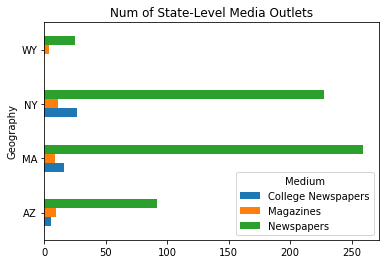

In [35]:
df_.plot(kind='barh', title="Num of State-Level Media Outlets");